In [2]:
import numpy as np
from scipy import fft, optimize
import NAFFlib as naf
import statistics as st
import matplotlib.pyplot as plt
import time
from IPython.display import display, Math
import re
import csv
from joblib import Parallel, delayed

#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)

# BPM Data

In [3]:
#Get data from all BPMs from sdds file
Name_xbpms = []
Name_ybpms = []
Pos_xbpms = np.zeros([1024, 168])
Pos_ybpms = np.zeros([1024, 167])
S_xbpms = np.zeros([1024, 168])
S_ybpms = np.zeros([1024, 167])
with open('data_Wed_Jun_28_20-13-14_2023') as output:
    Lines = output.readlines()
    index_ix = index_jx = 0
    index_iy = index_jy = 0
    init_i = 414
    for i, line in enumerate(Lines[1:]):
        Line = []
        #xBPM Names
        if i >= 67 and i < 95:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_xbpms.append(Line[:-1])
        
        #yBPM Names
        if i >= 241 and i < 269:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_ybpms.append(Line[:-1])
           
        #s and positions for xBPM
        if i > init_i:
            row = re.split("\s+", line)
            S_xbpms[index_ix][index_jx] = float(row[1])
            Pos_xbpms[index_ix][index_jx] = float(row[2])
            index_jx = (i - init_i)%168
            
            if (i - init_i)%168 == 0 and (i - init_i) != 0:
                index_ix += 1
        
        #s and positions for yBPM
        if i > init_i and i < 171423:
            row = re.split("\s+", line)
            S_ybpms[index_iy][index_jy] = float(row[6])
            Pos_ybpms[index_iy][index_jy] = float(row[7])
            index_jy = (i - init_i)%167
            
            if (i - init_i)%167 == 0 and (i - init_i) != 0:
                index_iy += 1
        
Name_xbpms = [item for row in Name_xbpms for item in row]
Name_ybpms = [item for row in Name_ybpms for item in row]

In [4]:
# Positions
init_turn = 0 # Starting turn
BPMx = Pos_xbpms.T[:, init_turn:] #np.loadtxt('BPMx.csv', delimiter=',')[:, init_turn:]
BPMy = Pos_ybpms.T[:, init_turn:] #np.loadtxt('BPMy.csv', delimiter=',')[:, init_turn:]

N_BPMx, N_turns = np.shape(BPMx) #(168, 1024-init_turn)
N_BPMy, _ = np.shape(BPMy) #(167, 1024-init_turn)

#Tunes
Nu_x_meas, Nu_y_meas = 28.235001748, 29.2290029334
nu_x_meas, nu_y_meas = Nu_x_meas%1, Nu_y_meas%1

x = np.linspace(init_turn, N_turns, N_turns)
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns

Standard deviation of First Horizontal BPM = 0.08086005371776343


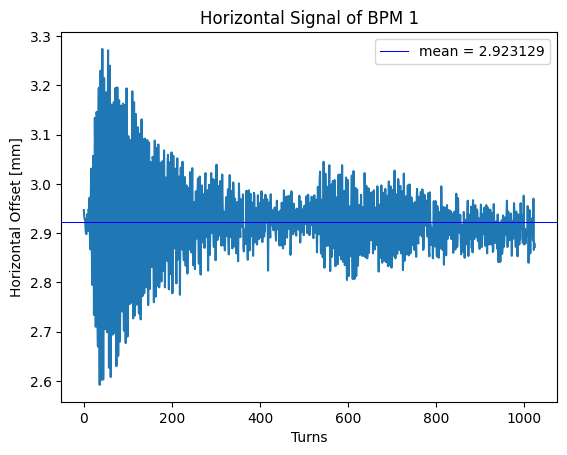

Standard deviation of First Vertical BPM = 0.14039846131415454


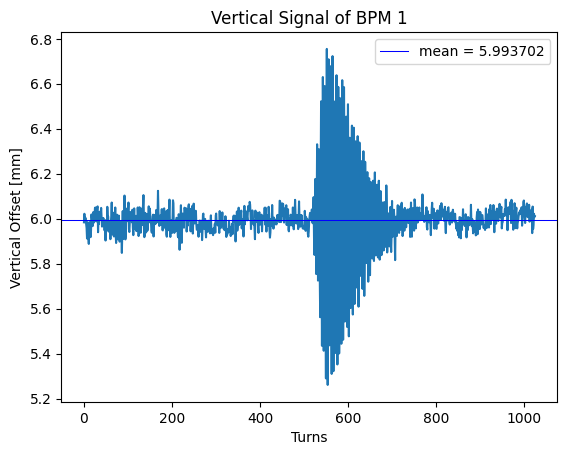

In [5]:
# Look at first BPM Signals
BPMx0 = BPMx[0]

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print("Standard deviation of First Horizontal BPM =", BPMx0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMx0)
plt.axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
plt.xlabel("Turns")
plt.ylabel("Horizontal Offset [mm]")
plt.title("Horizontal Signal of BPM 1")
plt.legend()
plt.show()

BPMy0 = BPMy[0]

BPMy0_mean = np.mean(BPMy0)
BPMy0_std = np.std(BPMy0)
print("Standard deviation of First Vertical BPM =", BPMy0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMy0)
plt.axhline(y = BPMy0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMy0_mean)
plt.xlabel("Turns")
plt.ylabel("Vertical Offset [mm]")
plt.title("Vertical Signal of BPM 1")
plt.legend()
plt.show()

0.23483365949119372


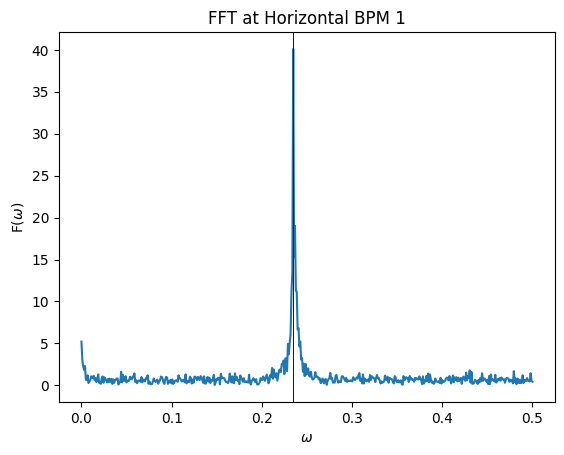

0.22896281800391388


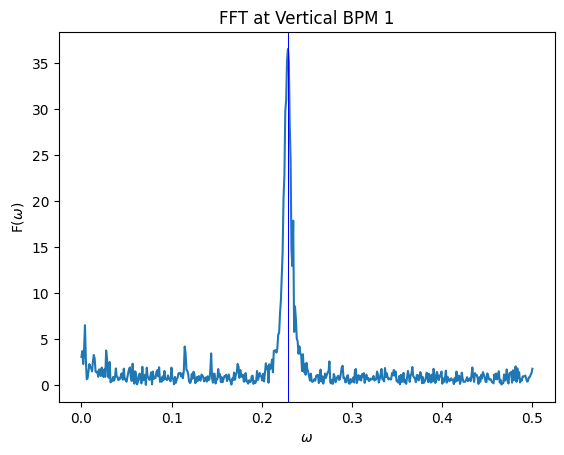

In [6]:
# Look at First BPM FFTs
BPMX0 = np.abs(fft.rfft(BPMx0)[1:])
BPMx0_Tune_scipy = Omega[np.argmax(BPMX0)]
print(BPMx0_Tune_scipy)
plt.plot(Omega, BPMX0)
plt.axvline(x = BPMx0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%BPMx0_Tune_scipy)
plt.title("FFT at Horizontal BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

BPMY0 = np.abs(fft.rfft(BPMy0)[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
print(BPMy0_Tune_scipy)
plt.plot(Omega, BPMY0)
plt.axvline(x = BPMy0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%BPMy0_Tune_scipy)
plt.title("FFT at Vertical BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

0.00016808850880467574 0.0010185889772997558


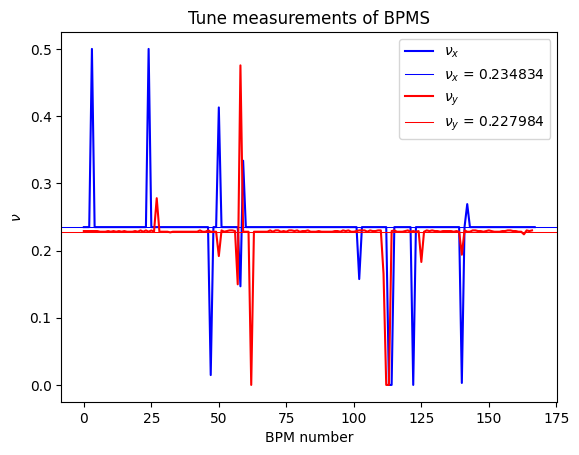

In [7]:
# Look at all FFTs to figure out Tune of machine
BPMx_Tune_Map = np.zeros(N_BPMx)
for i in range(N_BPMx):
    BPMX = np.abs(fft.rfft(BPMx[i])[1:]) 
    BPMx_Tune_Map[i] = Omega[np.argmax(BPMX)]
    # BPM 113 had a flat line

BPMy_Tune_Map = np.zeros(N_BPMy)
for i in range(N_BPMy):
    BPMY = np.abs(fft.rfft(BPMy[i])[1:])
    BPMy_Tune_Map[i] = Omega[np.argmax(BPMY)]

nu_x, nu_y = st.mode(BPMx_Tune_Map), st.mode(BPMy_Tune_Map)
#Difference from experiment
delta_nu_x, delta_nu_y = abs(nu_x_meas - nu_x), abs(nu_y_meas - nu_y)
print(delta_nu_x, delta_nu_y)

plt.plot(BPMx_Tune_Map, color = 'b', label = r"$\nu_x$")
plt.axhline(y = nu_x, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%nu_x)
plt.plot(BPMy_Tune_Map, color = 'r', label = r"$\nu_y$")
plt.axhline(y = nu_y, color = 'r', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%nu_y)
plt.xlabel("BPM number")
plt.ylabel(r"$\nu$")
plt.title("Tune measurements of BPMS")
plt.legend()
plt.show()

In [8]:
# Collect bad BPMs
def Bad_Bpms(Tune_Map, nu, N_BPM):
    Tune_Offset = np.abs(Tune_Map - np.ones(N_BPM)*nu)
    Bad_BPM = []
    for i, offset in enumerate(Tune_Offset):
        if offset > .01:
            Bad_BPM.append(i)
    return Bad_BPM

## Phase Transfer Matrix Calculation

In [56]:
print(Name_ybpms[50:])
print(S_ybpms[0, 50:])

['bi9-b7.1', 'bi9-b7', 'bi9-bv6', 'bi9-b4', 'bi9-b3', 'bi9-b1', 'g9-bx', 'g9-bx.2', 'g9-bx.1', 'g10-bx', 'bo10-b1', 'bo10-b3', 'bo10-b3.1', 'bo10-b4', 'bo10-bv5', 'bo10-b7', 'bo10-b8', 'bo10-bv9', 'bo10-bv11', 'bo10-bv13', 'bo10-bv15', 'bo10-bv17', 'bo10-bv19', 'bo11-bv21', 'bo11-bv19', 'bo11-bv17', 'bo11-bv15', 'bo11-bv13', 'bo11-bv11', 'bo11-bv9', 'bo11-b8', 'bo11-b7', 'bo11-bv5', 'bo11-b4', 'bo11-b3', 'bo11-b1', 'g11-bx', 'g12-bx', 'bi12-b1', 'bi12-b3', 'bi12-b4', 'bi12-bv6', 'bi12-b7', 'bi12-b8', 'bi12-bv10', 'bi12-bv12', 'bi12-bv14', 'bi12-bv16', 'bi12-bv18', 'bi12-bv20', 'bi1-bv20', 'bi1-bv18', 'bi1-bv16', 'bi1-bv14', 'bi1-bv12', 'bi1-bv10', 'bi1-b8', 'bi1-b7', 'bi1-bv6', 'bi1-b4', 'bi1-b3', 'bi1-b1', 'g1-bx', 'g2-bx', 'bo2-b1', 'bo2-b3', 'bo2-b4', 'bo2-bv5', 'bo2-b7', 'bo2-b8', 'bo2-bv9', 'bo2-bv11', 'bo2-bv13', 'bo2-bv15', 'bo2-bv17', 'bo2-bv19', 'bo3-bv21', 'bo3-bv19', 'bo3-bv17', 'bo3-bv15', 'bo3-bv13', 'bo3-bv11', 'bo3-bv9', 'bo3-b8', 'bo3-b7.1', 'bo3-b7', 'bo3-bv5', 'bo3-b4

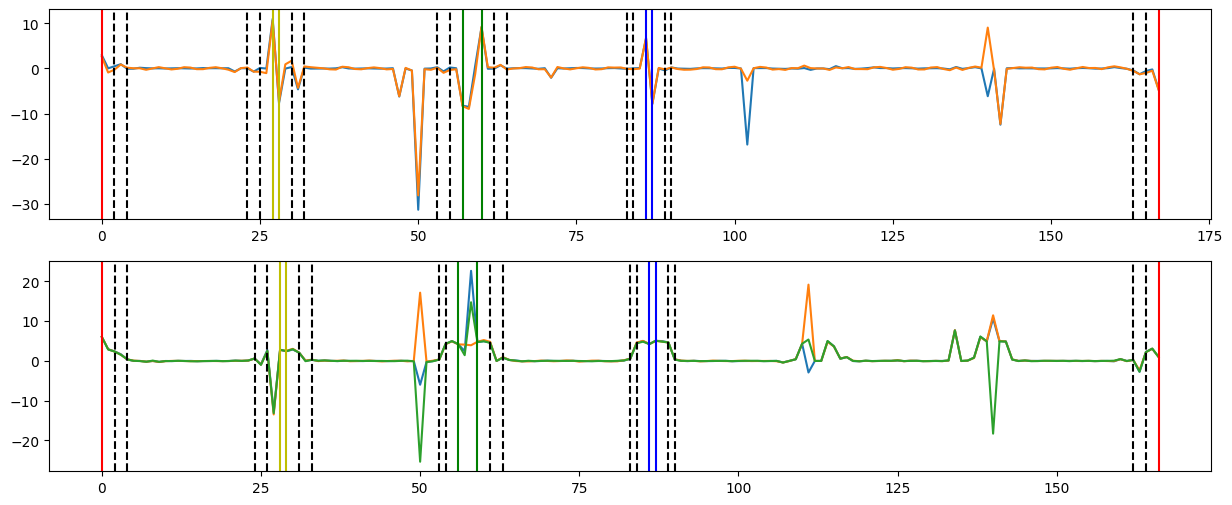

In [61]:
fig, Ax = plt.subplots(2, 1, figsize = (15, 6))
Ax[0].plot(Pos_xbpms[0, :])
Ax[0].plot(Pos_xbpms[36, :])

#IP6
Ax[0].axvline(x = 163, color = 'k', ls = '--')
Ax[0].axvline(x = 165, color = 'k', ls = '--')

Ax[0].axvline(x = 167, color = 'r')
Ax[0].axvline(x = 0, color = 'r')

Ax[0].axvline(x = 2, color = 'k', ls = '--')
Ax[0].axvline(x = 4, color = 'k', ls = '--')

#IP8
Ax[0].axvline(x = 23, color = 'k', ls = '--')
Ax[0].axvline(x = 25, color = 'k', ls = '--')

Ax[0].axvline(x = 27, color = 'y')
Ax[0].axvline(x = 28, color = 'y')

Ax[0].axvline(x = 30, color = 'k', ls = '--')
Ax[0].axvline(x = 32, color = 'k', ls = '--')

#IP10
Ax[0].axvline(x = 53, color = 'k', ls = '--')
Ax[0].axvline(x = 55, color = 'k', ls = '--')

Ax[0].axvline(x = 57, color = 'g')
Ax[0].axvline(x = 60, color = 'g')

Ax[0].axvline(x = 62, color = 'k', ls = '--')
Ax[0].axvline(x = 64, color = 'k', ls = '--')

#IP12
Ax[0].axvline(x = 83, color = 'k', ls = '--')
Ax[0].axvline(x = 84, color = 'k', ls = '--')

Ax[0].axvline(x = 86, color = 'b')
Ax[0].axvline(x = 87, color = 'b')

Ax[0].axvline(x = 89, color = 'k', ls = '--')
Ax[0].axvline(x = 90, color = 'k', ls = '--')

Ax[1].plot(Pos_ybpms[35, :])
Ax[1].plot(Pos_ybpms[36, :])
Ax[1].plot(Pos_ybpms[39, :])

#IP6
Ax[1].axvline(x = 162, color = 'k', ls = '--')
Ax[1].axvline(x = 164, color = 'k', ls = '--')

Ax[1].axvline(x = 0, color = 'r')
Ax[1].axvline(x = 166, color = 'r')

Ax[1].axvline(x = 2, color = 'k', ls = '--')
Ax[1].axvline(x = 4, color = 'k', ls = '--')

#IP8
Ax[1].axvline(x = 24, color = 'k', ls = '--')
Ax[1].axvline(x = 26, color = 'k', ls = '--')

Ax[1].axvline(x = 28, color = 'y')
Ax[1].axvline(x = 29, color = 'y')

Ax[1].axvline(x = 31, color = 'k', ls = '--')
Ax[1].axvline(x = 33, color = 'k', ls = '--')


#IP10
Ax[1].axvline(x = 53, color = 'k', ls = '--')
Ax[1].axvline(x = 54, color = 'k', ls = '--')

Ax[1].axvline(x = 56, color = 'g')
Ax[1].axvline(x = 59, color = 'g')

Ax[1].axvline(x = 61, color = 'k', ls = '--')
Ax[1].axvline(x = 63, color = 'k', ls = '--')

#IP12
Ax[1].axvline(x = 83, color = 'k', ls = '--')
Ax[1].axvline(x = 84, color = 'k', ls = '--')

Ax[1].axvline(x = 86, color = 'b')
Ax[1].axvline(x = 87, color = 'b')

Ax[1].axvline(x = 89, color = 'k', ls = '--')
Ax[1].axvline(x = 90, color = 'k', ls = '--')

plt.show()

## Linear Regression Calculation

In [73]:
def Mat_param(result):
    M = result.coef_
    print("M:")
    print(M)
    
    
    det = np.linalg.det(M)
    print("determinant:", det)
    M /= np.sqrt(np.sqrt(det))
    print("determinant after normalization:", np.linalg.det(M))
    print("M after normalization:")
    print(M)

    #Symplecticity check
    # [S2, 0]
    # [0, S2]
    S = np.matrix([[0, 1, 0, 0],
                   [-1, 0, 0, 0],
                   [0, 0, 0, 1],
                   [0, 0, -1, 0]])

    print("Symplecticity:")
    Sres = M @ S @ M.T
    print(Sres)
    print("Symplecticity Error:", mean_squared_error(np.asarray(Sres), np.asarray(S), squared = False))

    # Edward-Teng Parameterization
    A = np.matrix([M[0, :2], M[1, :2]])
    B = np.matrix([M[0, 2:], M[1, 2:]])
    C = np.matrix([M[2, :2], M[3, :2]])
    D = np.matrix([M[2, 2:], M[3, 2:]])

    lam = (np.trace(A) - np.trace(D))/2
    xi = 2*np.linalg.det(B) + np.trace(B @ C)
    delta = (lam**2 + xi)
    if delta > 0:
        kappa_alpha = (lam + np.sqrt(delta))/xi

        Mx = A - kappa_alpha*(np.linalg.det(B)*np.identity(2) + B @ C)
        My = D + kappa_alpha*(np.linalg.det(B)*np.identity(2) + C @ B)
        print()
        print("Stability:")
        print(((np.trace(A) + np.trace(D))/2 + np.sqrt(delta)))
        print(((np.trace(A) + np.trace(D))/2 + np.sqrt(delta)) < 2)
        print(abs((np.trace(A) + np.trace(D))/2 - np.sqrt(delta)))
        print(abs((np.trace(A) + np.trace(D))/2 - np.sqrt(delta)) < 2)
        print()

        M = np.matrix([[Mx[0, 0], Mx[0, 1], 0, 0],
                       [Mx[1, 0], Mx[1, 1], 0, 0],
                       [0, 0, My[0, 0], My[0, 1]],
                       [0, 0, My[1, 0], My[1, 1]]])
        print("M after Parameterization:")
        print(M)

    else:
        print("M not symplectic, no parameterization done")
    print()
        
    return M

In [33]:
# def Twiss_calc(M, s, s_IP):
def Twiss_calc(M):
    phix = np.arccos((M[0, 0] + M[1, 1])/2)
    betax = M[0, 1]/np.sin(phix)
    alphax = (M[0, 0] - M[1, 1])/(2*np.sin(phix))
    
    phiy = np.arccos((M[2, 2] + M[3, 3])/2)
    betay = M[2, 3]/np.sin(phiy)
    alphay = (M[2, 2] - M[3, 3])/(2*np.sin(phiy))
    print("tune x:", phix/(2*np.pi))
    print("tune y:", phiy/(2*np.pi))
    Twiss = np.array([phix, betax, alphax, phiy, betay, alphay])

    return Twiss

In [75]:
def LR_calculation(Intervals, Bpms, b_MADx):
    bpmx1, bpmx2, bpmy1, bpmy2 = Bpms
#     s1, s2, s_IP = S
#     bx1_m, by1_m, bsx_m, bsy_m, bx2_m, by2_m = b_MADx
    bx1_m, by1_m, bx2_m, by2_m = b_MADx
    
    #Organize position and speed data
    for i, (initial_turn, interval_turn) in enumerate(Intervals):
        
        # Scaled position and speed between two bpms
        Lx = S_xbpms[0, bpmx2] - S_xbpms[0, bpmx1]
        x_data1_all = BPMx[bpmx1] - np.mean(BPMx[bpmx1])
        x_data2_all = BPMx[bpmx2] - np.mean(BPMx[bpmx2])
        xp_data_all = (x_data2_all - x_data1_all)/Lx

#         L1x = S_xbpms[0, bpmx1 + 1] - S_xbpms[0, bpmx1]
#         L2x = S_xbpms[0, bpmx2] - S_xbpms[0, bpmx2 - 1]

#         x_data1n_all = BPMx[bpmx1 + 1] - np.mean(BPMx[bpmx1 + 1])
#         x_data2p_all = BPMx[bpmx2 - 1] - np.mean(BPMx[bpmx2 - 1])
        
#         xp_data1_all = (x_data1n_all - x_data1_all)/L1x
#         xp_data2_all = (x_data2_all - x_data2p_all)/L2x

        Ly = S_ybpms[0, bpmy2] - S_ybpms[0, bpmy1]
        y_data1_all = BPMy[bpmy1] - np.mean(BPMy[bpmy1])
        y_data2_all = BPMy[bpmy2] - np.mean(BPMy[bpmy2])
        yp_data_all = (y_data2_all - y_data1_all)/Ly

#         L1y = S_ybpms[0, bpmy1 + 1] - S_ybpms[0, bpmy1]
#         L2y = S_ybpms[0, bpmy2] - S_ybpms[0, bpmy2 - 1]
        
#         y_data1n_all = BPMy[bpmy1 + 1] - np.mean(BPMy[bpmy1 + 1])
#         y_data2p_all = BPMy[bpmy2 - 1] - np.mean(BPMy[bpmy2 - 1])
        
#         yp_data1_all = (y_data1n_all - y_data1_all)/L1y
#         yp_data2_all = (y_data2_all - y_data2p_all)/L2y

        # variable data: x_data (bpm, var) (current turn)
        x_data11 = x_data1_all[initial_turn: initial_turn + interval_turn]
        x_data12 = xp_data_all[initial_turn: initial_turn + interval_turn]
        x_data13 = y_data1_all[initial_turn: initial_turn + interval_turn]
        x_data14 = yp_data_all[initial_turn: initial_turn + interval_turn]

        x_data21 = x_data2_all[initial_turn: initial_turn + interval_turn]
        x_data22 = xp_data_all[initial_turn: initial_turn + interval_turn]
        x_data23 = y_data2_all[initial_turn: initial_turn + interval_turn]
        x_data24 = yp_data_all[initial_turn: initial_turn + interval_turn]

        X_data1_ = np.vstack((x_data11, x_data12, x_data13, x_data14)).T
        X_data2_ = np.vstack((x_data21, x_data22, x_data23, x_data24)).T
        if i == 0:
            X_data1 = X_data1_
            X_data2 = X_data2_

        else:
            X_data1 = np.concatenate((X_data1, X_data1_), axis = 0)
            X_data2 = np.concatenate((X_data2, X_data2_), axis = 0)

        # Y Train data (next turn)
        y_data11 = x_data1_all[initial_turn + 1: initial_turn + interval_turn + 1]
        y_data12 = xp_data_all[initial_turn + 1: initial_turn + interval_turn + 1]
        y_data13 = y_data1_all[initial_turn + 1: initial_turn + interval_turn + 1]
        y_data14 = yp_data_all[initial_turn + 1: initial_turn + interval_turn + 1]

        y_data21 = x_data2_all[initial_turn + 1: initial_turn + interval_turn + 1]
        y_data22 = xp_data_all[initial_turn + 1: initial_turn + interval_turn + 1]
        y_data23 = y_data2_all[initial_turn + 1: initial_turn + interval_turn + 1]
        y_data24 = yp_data_all[initial_turn + 1: initial_turn + interval_turn + 1]

        Y_data1_ = np.vstack((y_data11, y_data12, y_data13, y_data14)).T
        Y_data2_ = np.vstack((y_data21, y_data22, y_data23, y_data24)).T
        if i == 0:
            Y_data1 = Y_data1_
            Y_data2 = Y_data2_
        
        else:
            Y_data1 = np.concatenate((Y_data1, Y_data1_), axis = 0)
            Y_data2 = np.concatenate((Y_data2, Y_data2_), axis = 0)
            
    #LR Calculation:
    # Y = MX + B; M: 4x4
    result1 = LinearRegression().fit(X_data1, Y_data1)
    result2 = LinearRegression().fit(X_data2, Y_data2)

    #Correlation:
    corr1 = result1.score(X_data1, Y_data1)
    corr2 = result2.score(X_data2, Y_data2)
    print("Correlation from first bpm:", corr1)
    print("Correlation from second bpm:", corr2)
    print()
    
    #Prediction: Visualize correlation
    pred1 = result1.predict(X_data1)
    pred2 = result2.predict(X_data2)
    fig, Ax = plt.subplots(1, 2, figsize=(15, 6))
    Ax[0].scatter(pred1, Y_data1)
    Ax[0].set_title("prediction vs real for left bpm")
    Ax[0].set_xlabel("predicted next turn values")
    Ax[0].set_ylabel("Actual next turn values")
    
    Ax[1].scatter(pred2, Y_data2)
    Ax[1].set_title("prediction vs real for right bpm")
    Ax[1].set_xlabel("predicted next turn values")
    Ax[1].set_ylabel("Actual next turn values")
    plt.show()
    print()
    
    # Get Matrix M
    M1 = Mat_param(result1)
    M2 = Mat_param(result2)
    
    # Calculate Twiss parameters
    Twiss1 = Twiss_calc(M1)
    Twiss2 = Twiss_calc(M2)
    phix1, bx1, alphax1, phiy1, by1, alphay1 = Twiss1
    phix2, bx2, alphax2, phiy2, by2, alphay2 = Twiss2
    print("phix, betax, alphax, phiy, betay, alphay:")
    print("Measured Beta for left bpm:", bx1, by1)
    print("Model Beta for left bpm:", bx1_m, by1_m)
    print("Measured Beta for right bpm:", bx2, by2)
    print("Model Beta for right bpm:", bx2_m, by2_m)
    print()
    print("beta beat at left bpm:")
    print((bx1_m - bx1)/bx1_m, (by1_m - by1)/by1_m)
    print("beta beat at right bpm:")
    print((bx2_m - bx2)/bx2_m, (by2_m - by2)/by2_m)
    print()
    
    return Twiss1, Twiss2

### Around IP6

Correlation from first bpm: 0.14572521483001474
Correlation from second bpm: 0.14281909759602468



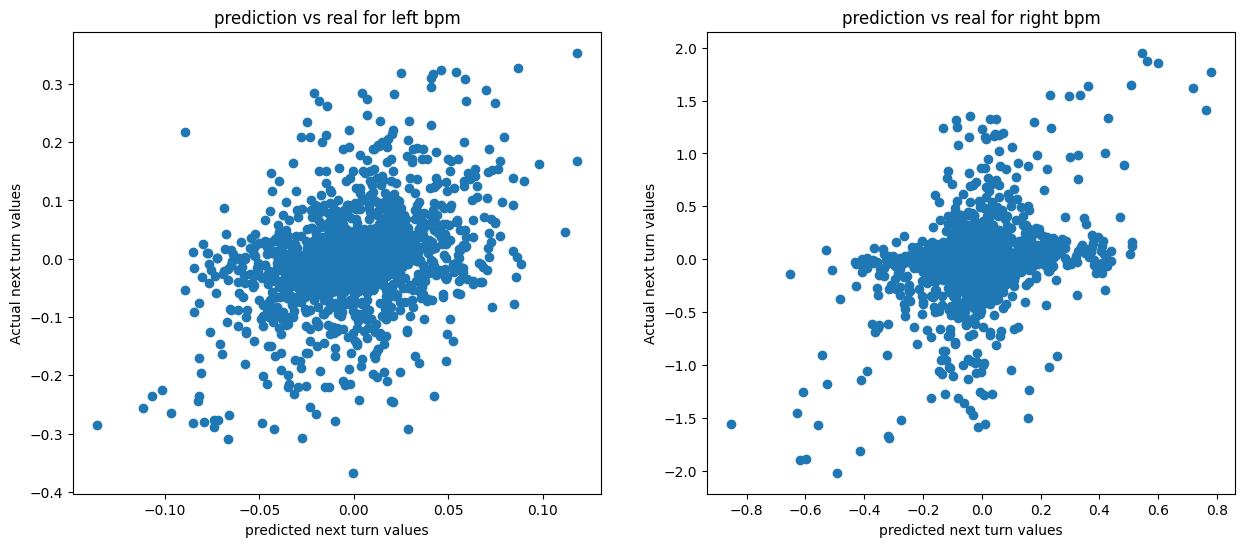


M:
[[ 0.3321902  -1.41113806 -0.0356917   0.68097266]
 [-0.01797708  0.21446395 -0.02254335 -0.03758522]
 [ 0.0030166   1.14535031  1.0863393   5.96777208]
 [-0.00274315 -0.18561908 -0.20324101 -0.92777843]]
determinant: 0.010578074790008087
determinant after normalization: 0.9999999999999992
M after normalization:
[[ 1.03582207 -4.4001537  -0.11129241  2.12338143]
 [-0.05605542  0.66873281 -0.07029375 -0.11719672]
 [ 0.00940624  3.57138509  3.38737934 18.60846585]
 [-0.00855357 -0.57878992 -0.63373792 -2.89296124]]
Symplecticity:
[[-0.          0.60833931 -5.52297108  1.0304716 ]
 [-0.60833931 -0.         -1.11755495  0.16724947]
 [ 5.52297108  1.11755495 -0.          2.01843716]
 [-1.0304716  -0.16724947 -2.01843716  0.        ]]
Symplecticity Error: 1.751563757777937

Stability:
1.7982652517108573
True
0.40070772264914145
True

M after Parameterization:
[[-0.49116187 12.9560875   0.          0.        ]
 [-0.05969695  0.89186959  0.          0.        ]
 [ 0.          0.          2

In [76]:
Intervals = [(35, 300), (535, 300)]

#downstream of IP6
Bpms = 163, 165, 162, 164
b_MADx = [67.80573273, 21.48144505, 1829.361467, 662.1839248]

#upstream of IP6
# Bpms = 2, 4, 2, 4
# b_MADx = [667.6941266, 1797.479291, 21.36609832, 66.69759845]

Twiss1, Twiss2 = LR_calculation(Intervals, Bpms, b_MADx)

### Around IP8

Correlation from first bpm: 0.1846534868513577
Correlation from second bpm: 0.18943414102116754



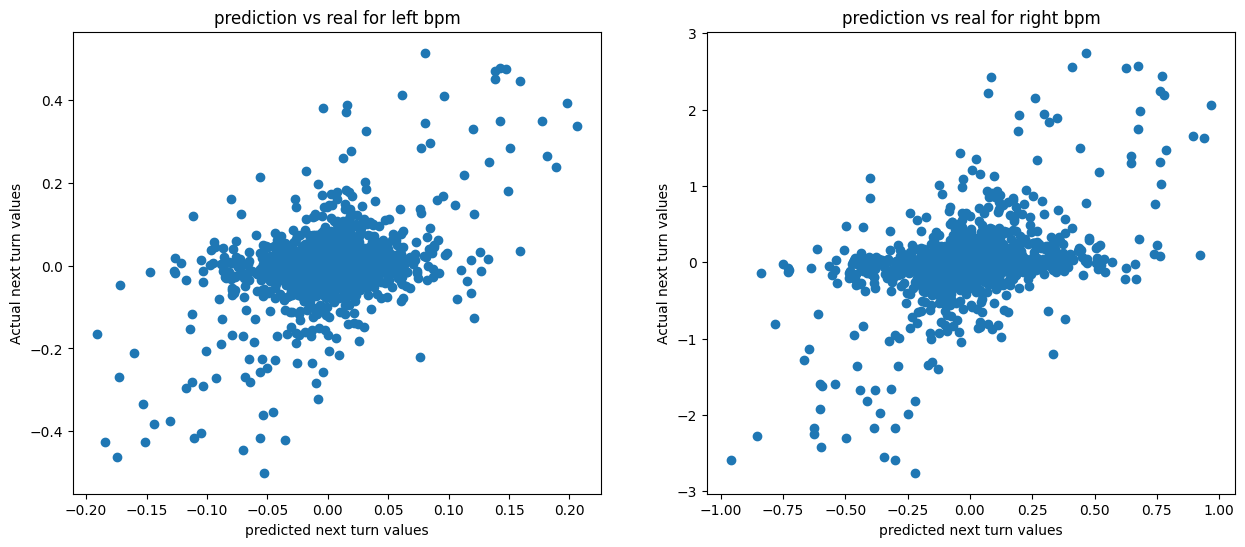


M:
[[ 0.64858487  4.27197161  0.1205708  -1.28764427]
 [-0.11186254 -0.57100334 -0.02378428  0.26341918]
 [-0.28614379 -2.73121958 -1.22294455 11.64679142]
 [-0.03830414 -0.390981   -0.16125515  1.38426559]]
determinant: 0.019047555857479942
determinant after normalization: 1.0000000000000018
M after normalization:
[[ 1.74585028 11.49922425  0.32455053 -3.46606008]
 [-0.30110979 -1.53701757 -0.06402214  0.7090675 ]
 [-0.77023723 -7.35185282 -3.29190241 31.35064527]
 [-0.10310648 -1.05243636 -0.43406401  3.72614377]]
Symplecticity:
[[ 0.          0.78735005 -5.21316671 -0.94692185]
 [-0.78735005  0.          1.35689229  0.22764741]
 [ 5.21316671 -1.35689229 -0.          1.39468723]
 [ 0.94692185 -0.22764741 -1.39468723  0.        ]]
Symplecticity Error: 1.6433831805246475
M not symplectic, no parameterization done

M:
[[ -3.41192842 107.39508913  -0.74277793  35.23643867]
 [ -0.11186254   3.48950995  -0.02378428   1.12676791]
 [ -1.67655098  43.93385594  -7.07636669 318.76040777]
 [ -0

In [79]:
Intervals = [(35, 300), (535, 300)]
#downstream of IP8
Bpms = 23, 25, 24, 26
b_MADx = [19.87322377, 62.79285429, 661.517763, 1770.202631]

#upstream of IP8
# Bpms = 30, 32, 31, 33
# b_MADx = [1814.716854, 649.6131896, 65.47615064, 20.29859581]
Twiss1, Twiss2 = LR_calculation(Intervals, Bpms, b_MADx)

### Around IP10

Correlation from first bpm: 0.4793436042157506
Correlation from second bpm: 0.4615404178409904



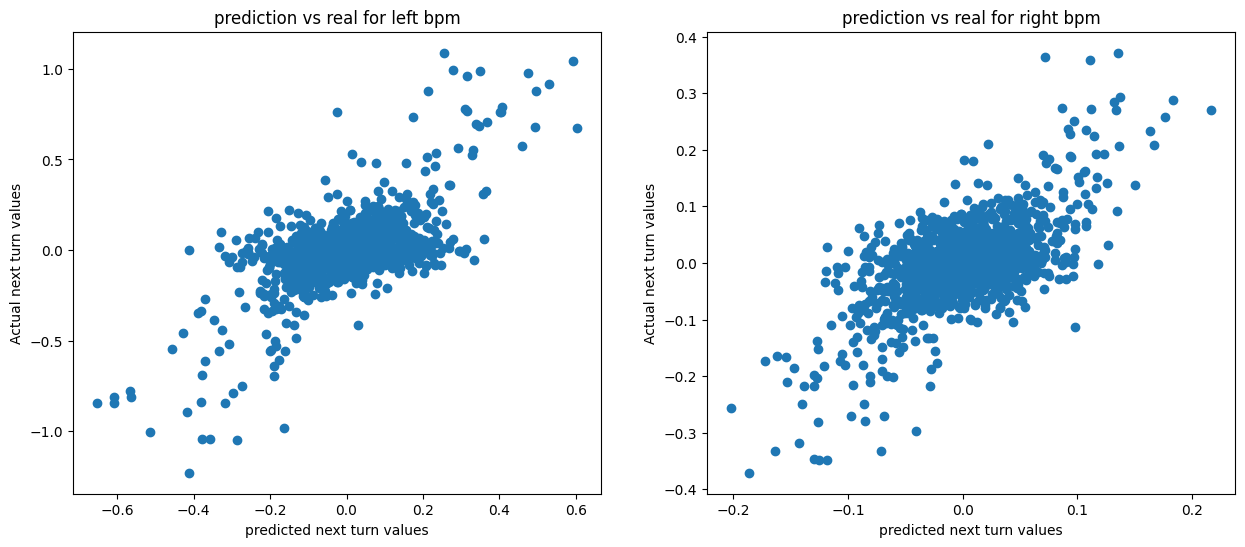


M:
[[  1.76270011  47.26037852   0.04875922  -2.39833122]
 [ -0.06880137  -1.5754256   -0.00302205   0.00735755]
 [ -0.99611985 -20.14360069   2.35381845 112.48681775]
 [  0.01620073   0.31427271  -0.04959805  -2.22234928]]
determinant: 0.15709377958949233
determinant after normalization: 0.9999999999999951
M after normalization:
[[  2.79987527  75.06844996   0.07744921  -3.8095126 ]
 [ -0.10928418  -2.50240818  -0.00480022   0.01168674]
 [ -1.58223814 -31.99612292   3.73880845 178.67421536]
 [  0.02573327   0.49919121  -0.0787816   -3.52998264]]
Symplecticity:
[[  0.           1.17998214  57.27222651  -1.10759734]
 [ -1.17998214   0.          -1.36410592   0.02770684]
 [-57.27222651   1.36410592  -0.           0.91183777]
 [  1.10759734  -0.02770684  -0.91183777  -0.        ]]
Symplecticity Error: 14.632426067734915
M not symplectic, no parameterization done

M:
[[-0.73297863 16.70172651 -0.06086152  0.07622529]
 [-0.06880137  0.92025313 -0.00302205  0.11697828]
 [-0.40845961  6.0725

In [81]:
Intervals = [(35, 300), (535, 300)]
#downstream of IP10
# Bpms = 53, 55, 53, 54
# b_MADx = [25.55882593, 21.81527574, 259.1350568, 92.99599271]

#upstream of IP10
Bpms = 62, 64, 61, 63
b_MADx = [94.60224219, 260.6868242, 17.45850739, 26.88939256]

Twiss1, Twiss2 = LR_calculation(Intervals, Bpms, b_MADx)

### Around IP12 

Correlation from first bpm: 0.4610826994422066
Correlation from second bpm: 0.45432637141352633



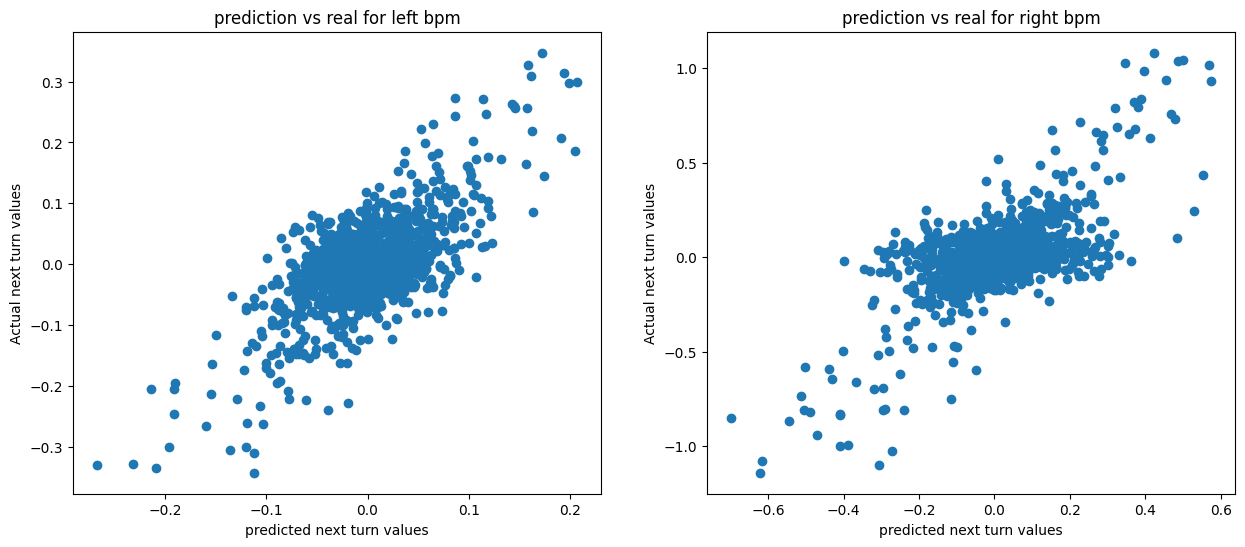


M:
[[ 0.83839037 14.89301388 -0.09486229  0.91794144]
 [-0.06122965 -0.59255746  0.0087208  -0.17044419]
 [ 0.33132167  3.36063722 -0.47747042 13.09357821]
 [ 0.01921035  0.27528696 -0.05451701  0.68826208]]
determinant: 0.14707985971441878
determinant after normalization: 1.0000000000000004
M after normalization:
[[ 1.35381082 24.04884884 -0.15318114  1.4822678 ]
 [-0.09887203 -0.95684626  0.01408213 -0.27522882]
 [ 0.53500955  5.42666898 -0.77100674 21.14316724]
 [ 0.03102037  0.44452618 -0.08803264  1.11138758]]
Symplecticity:
[[ 0.          1.10365614 -7.6155765  -0.18395557]
 [-1.10365614 -0.          0.06091357 -0.0228479 ]
 [ 7.6155765  -0.06091357 -0.          1.07389002]
 [ 0.18395557  0.0228479  -1.07389002 -0.        ]]
Symplecticity Error: 1.9445769492604816
M not symplectic, no parameterization done

M:
[[ -1.38263431  43.55200873   0.22147338 -13.29835136]
 [ -0.06122965   1.62846723   0.0087208   -0.48677986]
 [  1.02815182 -23.94854166  -2.45500305 127.1113717 ]
 [  0.

In [83]:
Intervals = [(35, 300), (535, 300)]
#downstream of IP12
Bpms = 83, 84, 83, 84
b_MADx = [20.60080992, 26.4804521, 94.79244064, 261.2369843]

#upstream of IP12
# Bpms = 89, 90, 89, 90
# b_MADx = [259.7640288, 94.20459319, 26.73997493, 21.34783386]

Twiss1, Twiss2 = LR_calculation(Intervals, Bpms, b_MADx)

In [80]:
#plot_correlations(X_data1, Y_data1, X_data2, Y_data2, bpm1, bpm2)

In [81]:
phi1, beta1, alpha1, bs1, ss1 = Twiss1
phi2, beta2, alpha2, bs2, ss2 = Twiss2
b1_m = 19.15235045
bs_m = 4.987128909
b2_m = 18.63167495

print("phi, beta, alpha from LR at bpm 86:", phi1, beta1, alpha1)
print("beta*, s*, and delta s* calculated from beta and alpha at bpm 86", bs1, ss1, ss1 - sIP12)
print("phi, beta, alpha from MADx at bpm 86:", 14.42075716, b1_m, 1.68561401)
print("beta beat at bpm 86:", (b1_m - beta1)/b1_m)
print("beta beat at b* from bpm 86:", (bs_m - bs1)/bs_m)
print()
print("phi, beta, alpha from LR at bpm 87:", phi2, beta2, alpha2)
print("beta*, s*, and delta s* calculated from beta and alpha at bpm 87", bs2, ss2, ss2 - sIP12)
print("phi, beta, alpha from MADx at bpm 87:", 14.74900606, b2_m, -1.654347369)
print("beta beat at bpm 87:", (b2_m - beta2)/b2_m)
print("beta beat at b* from bpm 87:", (bs_m - bs2)/bs_m)
print()
bs_2, ss_2 = L_86_87/(alpha1 - alpha2), s_86 + L_86_87*alpha1/(alpha1 - alpha2)
print("beta*, s*, and delta s* calculated from both bpms:", bs_2, ss_2, ss_2 - sIP12)
print("beta beat at b* from both bpms:", (bs_m - bs_2)/bs_m)

phi, beta, alpha from LR at bpm 86: 1.4213074072815985 16.85329971074599 1.0788638719886836
beta*, s*, and delta s* calculated from beta and alpha at bpm 86 7.7882211210987675 1278.0245003946125 -639.3689223734275
phi, beta, alpha from MADx at bpm 86: 14.42075716 19.15235045 1.68561401
beta beat at bpm 86: 0.12004013529597932
beta beat at b* from bpm 86: -0.5616642888544126

phi, beta, alpha from LR at bpm 87: 1.4213074072816023 8.791237271812983 -0.5947347158975037
beta*, s*, and delta s* calculated from beta and alpha at bpm 87 6.494183601592075 1282.4124635607209 -634.9809592073191
phi, beta, alpha from MADx at bpm 87: 14.74900606 18.63167495 -1.654347369
beta beat at bpm 87: 0.5281563629998288
beta beat at b* from bpm 87: -0.30218883852638656

beta*, s*, and delta s* calculated from both bpms: 9.950313127972397 1919.802053348744 2.4086305807040844
beta beat at b* from both bpms: -0.9951987024068314
